In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Question 1
### Q1.1

I choose Linear Regression Model  I decided to choose this model because it is the most straight forward model and what I am comfortable with. In addition linear regression is a useful baseline with no built in bias or additional parameters that would be used to reduce variance. Since I do not know what the data set looks like yet,this model provides the best first unbiased glance. I choose the Statsmodels library because of the build in cook's distance feature.
 

In [63]:
df = pd.read_csv('usina_with_outliers.csv')
print("Shape:", df.shape)
display(df.head())

target_col = df.columns[-1]
print("Target column:", target_col)

Shape: (9568, 5)


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


Target column: PE


In [65]:
# Helper function 
def fit_ols_diagnostics(X, y):
    """Fit OLS and return (model, diagnostics dataframe)."""
    X = np.asarray(X)
    y = np.asarray(y).reshape(-1)
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    # Add intercept column for statsmodels
    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm).fit()

    infl = OLSInfluence(model)
    diag = pd.DataFrame({
        "y": y,
        "y_hat": model.fittedvalues,
        "residual": model.resid,
        "leverage_hii": infl.hat_matrix_diag,   # diagonal of Hat matrix H
        "cooks_D": infl.cooks_distance[0]
    })
    return model, diag



In [67]:
X = df[['AT', 'V', 'AP', 'RH']]
y = df['PE']

# Fit model and get diagnostics using your function
model, diagnostics = fit_ols_diagnostics(X, y)

# Identify outliers using the 4/n threshold rule
n = len(df)
threshold = 4 / n
outliers_mask = diagnostics['cooks_D'] > threshold

# Count how many outliers were found
num_outliers = outliers_mask.sum()
print(f"Total data points: {n}")
print(f"Cook's Distance Threshold (4/n): {threshold:.6f}")
print(f"Identified {num_outliers} outliers.")

# 5. Remove detected outliers
df_clean = df[~outliers_mask].copy()

# 6. Export the cleaned dataset
df_clean.to_csv('usina.csv', index=False)
print("Cleaned dataset exported to 'usina.csv'")

Total data points: 9568
Cook's Distance Threshold (4/n): 0.000418
Identified 120 outliers.
Cleaned dataset exported to 'usina.csv'


In [69]:
# Training helper
def split_train_test(x, y, train_frac=0.7, split_mode="random", seed=42):
    """
    split_mode:
      - "random": shuffle then split
      - "ordered_contiguous": sort by x ascending (low->high), then split
    """
    x = np.asarray(x)
    y = np.asarray(y)

    if not (0.0 < train_frac < 1.0):
        raise ValueError("train_frac must be between 0 and 1.")

    test_size = 1.0 - train_frac

    if split_mode == "random":
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=test_size, random_state=seed, shuffle=True
        )
        return x_train, x_test, y_train, y_test

    if split_mode == "ordered_contiguous":
        idx = np.argsort(x)
        x_sorted = x[idx]
        y_sorted = y[idx]

        n = len(x_sorted)
        n_train = int(np.floor(train_frac * n))

        return (x_sorted[:n_train], x_sorted[n_train:],
                y_sorted[:n_train], y_sorted[n_train:])

    raise ValueError("split_mode must be 'random' or 'ordered_contiguous'.")

## Q2: Train/Test Evaluation
### Q2.1

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True
)

alphas = [0.01, 0.1, 1, 10, 100]
trained_models = {}

print("--- Training Models on usina_with_outliers.csv ---")

# A. Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
trained_models['Linear'] = lin_reg
print("Linear Regression trained.")

# B. Ridge Regression
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train, y_train)
    trained_models[f'Ridge_alpha_{a}'] = ridge
    print(f"Ridge (alpha={a}) trained.")

# C. Lasso Regression
for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    trained_models[f'Lasso_alpha_{a}'] = lasso
    print(f"Lasso (alpha={a}) trained.")

--- Training Models on usina_with_outliers.csv ---
Linear Regression trained.
Ridge (alpha=0.01) trained.
Ridge (alpha=0.1) trained.
Ridge (alpha=1) trained.
Ridge (alpha=10) trained.
Ridge (alpha=100) trained.
Lasso (alpha=0.01) trained.
Lasso (alpha=0.1) trained.
Lasso (alpha=1) trained.
Lasso (alpha=10) trained.
Lasso (alpha=100) trained.


### Q2.2

In [75]:
df_clean = pd.read_csv('usina.csv')

X_clean = df_clean[['AT', 'V', 'AP', 'RH']]
y_clean = df_clean['PE']

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.30, random_state=42, shuffle=True
)

alphas = [0.01, 0.1, 1, 10, 100]
cleaned_models = {}

print("--- Training Models on usina.csv (Cleaned Data) ---")

# A. Linear Regression
lin_reg_clean = LinearRegression()
lin_reg_clean.fit(X_train_clean, y_train_clean)
cleaned_models['Linear'] = lin_reg_clean
print("Linear Regression trained.")

# B. Ridge Regression
for a in alphas:
    ridge = Ridge(alpha=a)
    ridge.fit(X_train_clean, y_train_clean)
    cleaned_models[f'Ridge_alpha_{a}'] = ridge
    # print(f"Ridge (alpha={a}) trained.") # Optional: verify progress

# C. Lasso Regression
for a in alphas:
    lasso = Lasso(alpha=a)
    lasso.fit(X_train_clean, y_train_clean)
    cleaned_models[f'Lasso_alpha_{a}'] = lasso
    # print(f"Lasso (alpha={a}) trained.") # Optional: verify progress

--- Training Models on usina.csv (Cleaned Data) ---
Linear Regression trained.


### Q2.3

In [58]:
def eval_metrics(y_true, y_pred):
    """Calculates the specific metrics required for Q2."""
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2":  r2_score(y_true, y_pred)
    }

def generate_q2_report(models_dict, X_train, y_train, X_test, y_test):
    """
    Applies the evaluation logic to a dictionary of models.
    Returns a DataFrame formatted for the Q2 requirements.
    """
    results_data = []

    for name, model in models_dict.items():
        pred_tr = model.predict(X_train)
        pred_te = model.predict(X_test)

        train_metrics = eval_metrics(y_train, pred_tr)
        test_metrics = eval_metrics(y_test, pred_te)

        if "Linear" in name:
            model_type = "Linear Regression"
            lam = "N/A"
        else:
            parts = name.split('_')
            model_type = parts[0]
            lam = parts[2]  

        row = {
            "Model": model_type,
            "Lambda": lam,
            "Train MSE": train_metrics["MSE"],
            "Train MAE": train_metrics["MAE"],
            "Train R2":  train_metrics["R2"],
            "Test MSE":  test_metrics["MSE"],
            "Test MAE":  test_metrics["MAE"],
            "Test R2":   test_metrics["R2"]
        }
        results_data.append(row)
    return pd.DataFrame(results_data)
q2_results_unclean_df = generate_q2_report(
    trained_models,
    X_train, y_train,
    X_test, y_test
)
q2_results_df = generate_q2_report(
    cleaned_models, 
    X_train_clean, y_train_clean, 
    X_test_clean, y_test_clean
)

cols = ["Model", "Lambda", "Train MSE", "Train MAE", "Train R2", "Test MSE", "Test MAE", "Test R2"]
print("Q2 Performance Report (Uncleaned Data):")
display(q2_results_unclean_df[cols])

print("Q2 Performance Report (Cleaned Data):")
display(q2_results_df[cols])

Q2 Performance Report (Uncleaned Data):


,Model,Lambda,Train MSE,Train MAE,Train R2,Test MSE,Test MAE,Test R2
0,Linear Regression,N/A,123.384207,5.198679,0.650171,125.113389,5.052458,0.642574
1,Ridge,0.01,123.384207,5.198679,0.650171,125.113389,5.052458,0.642574
2,Ridge,0.1,123.384207,5.198680,0.650171,125.113392,5.052459,0.642574
3,Ridge,1,123.384207,5.198685,0.650171,125.113421,5.052463,0.642574
4,Ridge,10,123.384207,5.198737,0.650171,125.113705,5.052513,0.642573
5,Ridge,100,123.384213,5.199261,0.650171,125.116548,5.053003,0.642565
6,Lasso,0.01,123.384210,5.198858,0.650171,125.115332,5.052626,0.642568
7,Lasso,0.1,123.384607,5.201739,0.650169,125.134495,5.055348,0.642514
8,Lasso,1,123.421151,5.229507,0.650066,125.338356,5.083092,0.641931
9,Lasso,10,126.141514,5.540418,0.642353,128.902136,5.408803,0.631750


Q2 Performance Report (Cleaned Data):


,Model,Lambda,Train MSE,Train MAE,Train R2,Test MSE,Test MAE,Test R2
0,Linear Regression,N/A,19.864671,3.596396,0.931369,20.396772,3.624773,0.930302
1,Ridge,0.01,19.864671,3.596396,0.931369,20.396772,3.624773,0.930302
2,Ridge,0.1,19.864671,3.596397,0.931369,20.396770,3.624773,0.930302
3,Ridge,1,19.864671,3.596400,0.931369,20.396750,3.624774,0.930302
4,Ridge,10,19.864672,3.596430,0.931369,20.396549,3.624783,0.930303
5,Ridge,100,19.864758,3.596742,0.931369,20.394626,3.624880,0.930310
6,Lasso,0.01,19.864675,3.596368,0.931369,20.396738,3.624754,0.930302
7,Lasso,0.1,19.865263,3.596855,0.931367,20.392600,3.624890,0.930316
8,Lasso,1,19.929852,3.605523,0.931144,20.414755,3.631153,0.930241
9,Lasso,10,25.685683,4.086632,0.911258,26.157253,4.120464,0.910618


### Discussion
The outliers drastically change the train and test errors. The clean dataset has better generalization
shown by significantly lower MSE (~100) and the test/train MSE are similar. The Ridge/Lasso doesn't appear to help nor worsen relative to the linear regression. In the uncleaned data, linear regression model performed the best. In cleaned version Lasso with lambda = 0.1 performed the best but by a tiny difference compared to linear Regression.


## Question 3
### Q 3.1

I select the Linear Regression model using Statsmodels OLS. Linear Regression has proven to be a solid model based on previous questions and linear regression removes the bias to reduce variance that could effect calcualted p-values/confidence intervals for each coefficient.

In [79]:
df = pd.read_csv('usina.csv')
X = df[['AT', 'V', 'AP', 'RH']]
y = df['PE']

X_sm = sm.add_constant(X)
model_ols = sm.OLS(y, X_sm).fit()

t_stats = model_ols.tvalues.drop('const').abs()

print("=== Q3: Reliability (Based on t-statistics) ===")
print(f"Most Reliable (Best):  {t_stats.idxmax()} (t = {t_stats.max():.4f})")
print(f"Least Reliable (Worst): {t_stats.idxmin()} (t = {t_stats.min():.4f})")
print("\nFull Reliability Ranking (t-stats):")
print(t_stats.sort_values(ascending=False))


=== Q3: Reliability (Based on t-statistics) ===
Most Reliable (Best):  AT (t = 129.1130)
Least Reliable (Worst): AP (t = 7.8945)

Full Reliability Ranking (t-stats):
AT    129.113036
RH     36.897303
V      33.056481
AP      7.894540
dtype: float64


The most reliable coefficient is AT because it has the highest t-value 

## Question 4
### Q4.1

I select Lassa model because it is good for feature selection by shrinking the unimportant coefficients. It makes it very clear which features are important. I will also use Scikit-learn because it's easier to use with lasso. I would scale the IVs because I need to compare the magnitude of coefficients which could be on different scales.

### Q 4.2

In [92]:
df_clean = pd.read_csv('usina.csv')
X = df_clean[['AT', 'V', 'AP', 'RH']]
y = df_clean['PE']

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.30, random_state=42
)

alphas = [0.01, 0.1, 1, 10, 100]
best_alpha = None
best_mse = float('inf')
best_model = None

print("--- Tuning Lasso for Q4 ---")
for a in alphas:
    lasso = Lasso(alpha=a, random_state=42)
    lasso.fit(X_train, y_train)
    
    y_pred = lasso.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    print(f"Alpha: {a:<5} | Test MSE: {mse:.4f}")
    
    if mse < best_mse:
        best_mse = mse
        best_alpha = a
        best_model = lasso

print(f"\n✅ Best Alpha selected: {best_alpha}")

# Analyze Coefficients of the Best Model
coeffs = pd.Series(np.abs(best_model.coef_), index=X.columns)

print("\n" + "="*50)
print("Q4 Results (Using Best Lasso Model)")
print("="*50)
print("Feature Importance (Absolute Coefficients):")
print(coeffs.sort_values(ascending=False))

print("\nAnswers:")
print(f"Most Important Feature:  {coeffs.idxmax()} (Weight: {coeffs.max():.4f})")
print(f"Least Important Feature: {coeffs.idxmin()} (Weight: {coeffs.min():.4f})")


--- Tuning Lasso for Q4 ---
Alpha: 0.01  | Test MSE: 20.3936
Alpha: 0.1   | Test MSE: 20.4053
Alpha: 1     | Test MSE: 24.7825
Alpha: 10    | Test MSE: 130.4886
Alpha: 100   | Test MSE: 292.6822

✅ Best Alpha selected: 0.01

Q4 Results (Using Best Lasso Model)
Feature Importance (Absolute Coefficients):
AT    14.620733
V      2.991368
RH     2.206739
AP     0.425194
dtype: float64

Answers:
Most Important Feature:  AT (Weight: 14.6207)
Least Important Feature: AP (Weight: 0.4252)


The most imporant feature is 'AT' with a weight of ~14.6 while the least important is 'AP' with an almost 0 weight.  

## Question 5
### 5.1

Calculating Regularization Paths...
Calculation complete. Generating plots...


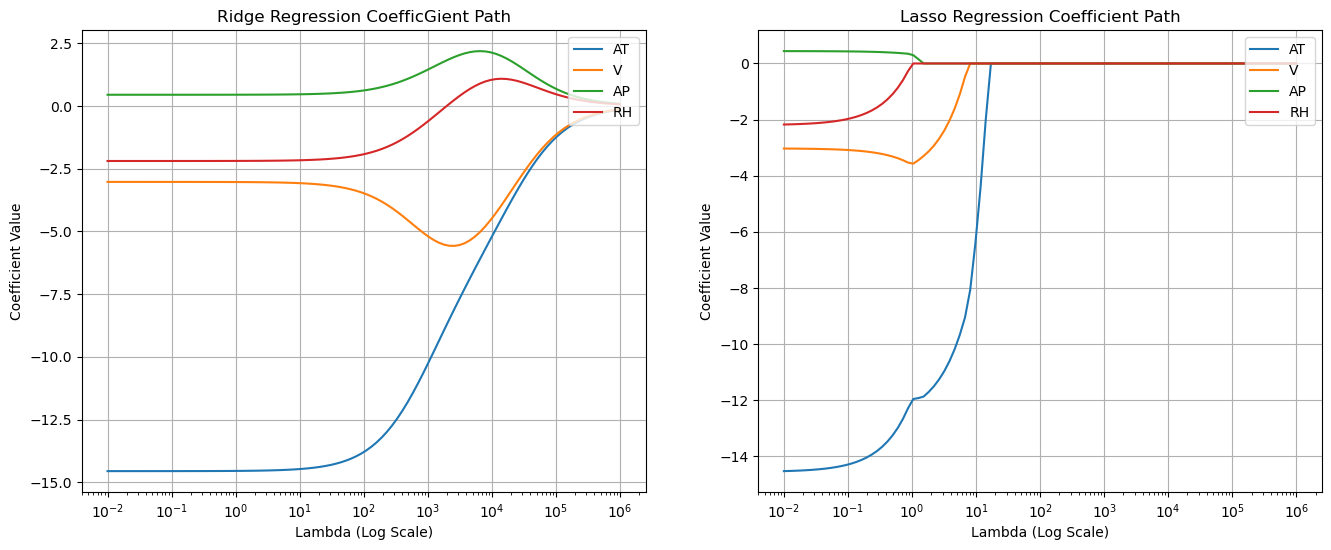

In [94]:
X = df_clean[['AT', 'V', 'AP', 'RH']]
y = df_clean['PE']

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

lambdas = np.logspace(-2, 6, 100)

ridge_coefs = []
lasso_coefs = []

print("Calculating Regularization Paths...")

for lam in lambdas:
    ridge = Ridge(alpha=lam)
    ridge.fit(X_scaled, y)
    ridge_coefs.append(ridge.coef_)
    
    lasso = Lasso(alpha=lam)
    lasso.fit(X_scaled, y)
    lasso_coefs.append(lasso.coef_)

print("Calculation complete. Generating plots...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(lambdas, ridge_coefs)
ax1.set_xscale('log')  # Log scale for X-axis makes it readable
ax1.set_xlabel('Lambda (Log Scale)')
ax1.set_ylabel('Coefficient Value')
ax1.set_title('Ridge Regression CoefficGient Path')
ax1.legend(X.columns, loc='upper right')
ax1.grid(True)

ax2.plot(lambdas, lasso_coefs)
ax2.set_xscale('log')
ax2.set_xlabel('Lambda (Log Scale)')
ax2.set_ylabel('Coefficient Value')
ax2.set_title('Lasso Regression Coefficient Path')
ax2.legend(X.columns, loc='upper right')
ax2.grid(True)

plt.show()

As lambda increase both ridge and lasso coefficients approach 0 but lasso approaches 0 faster than ridge. Ridge regression is better under multicollinearity because it better distributes the weight of coefficients more evenly which preserves more information. Compared to lasso which 'selects' the most reliable feature and reduces the other coefficients to 0 quickly. This feature however makes it good at feature selection because it minimizes unimportant features to 0 making it very clear.